env = CartPole-v1 <br>
Pole balancing problem with continuous state variables. <br>
Double Deep Q Learning <br>

!! i took some implementation tricks from other existing creations !!

In [11]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [12]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()

        # input: state, outputs 128 features
        self.layer1 = nn.Linear(n_observations, 128)

        # 128 -> 128
        self.layer2 = nn.Linear(128, 128)

        # input 128 features, outputs: (q left, q right) action
        self.layer3 = nn.Linear(128, n_actions)

    # output function
    def forward(self, x):
        # layer 1 reLu
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))

        # output layer, no activation. raw values
        return self.layer3(x)

In [13]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [14]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [17]:
env = gym.make("CartPole-v1")

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

In [18]:
def select_action(state):
    global steps_done
    sample = random.random()

    # epsilon management
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)

    steps_done += 1

    # exploitation
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)

    # exploration
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [19]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    # random batch of 128 memories
    transitions = memory.sample(BATCH_SIZE)

    # list of arrays to array of lists
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # current q
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # target q. all next state values are 0 initially
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # what the best next move is, acc to the target
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # reward + gamma * max(q next)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # loss = (guess-target)^2
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # update
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    optimizer.step()

Trial 0. 16 steps
Trial 50. 13 steps
Trial 100. 13 steps
Trial 150. 14 steps
Trial 200. 131 steps
Trial 250. 136 steps
Trial 300. 132 steps
Trial 350. 176 steps
Trial 400. 159 steps
Trial 450. 501 steps


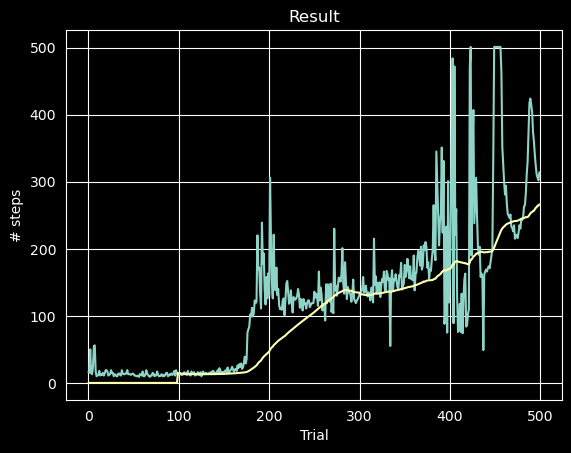

In [20]:
num_episodes = 500

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Trial')
    plt.ylabel('# steps')
    plt.plot(durations_t.numpy())

    # Take 100-episode moving average
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # Pause to update plots

for i_episode in range(num_episodes):
    # reset
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in range(1, 10000):
        # epsilon greedy action
        action = select_action(state)

        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        # next state
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # memory
        memory.push(state, action, next_state, reward, done)

        state = next_state

        # train
        optimize_model()

        # target w = τ * policy w + (1-τ) * target w
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            if i_episode % 50 == 0:
                print(f"Trial {i_episode}. {t+1} steps")
            break

plot_durations(show_result=True)
plt.show()
